# Trabajo Ciencia de Datos en biomedicina 

### Manel Soler Sanz
### Bobby Risckson


### Registration 
https://www.kaggle.com/boojum/connecting-voxel-spaces/
![](https://sun9-45.userapi.com/impg/Flbnug2OUli1ecXsoIKeUasIGXGj_5hqjX4cRg/z2nfz8-b3a0.jpg?size=2560x1153&quality=96&sign=0536543610f1655d967af88dbc775e98&type=album)

### Segmentation 
Unet
https://pytorch.org/hub/mateuszbuda_brain-segmentation-pytorch_unet/

### Features

https://pyradiomics.readthedocs.io/en/latest/features.html#module-radiomics.shape2D

# Trabajo de segmentacion

Primeramente vamos a extraer características de cada una de las imagenes junto a su segmentación. Estas características las conseguiremos utilizando la libreria de `Pyradiomics`. 
Una vez tengamos un data frame con características de  300 imagenes, entrenaremos un clasificador para evaluar el rendimiento de deteeccion del tumor así como las características más importantes en la detección de este.

In [1]:
!pip install pyradiomics

     |████████████████████████████████| 188 kB 595 kB/s 
     |████████████████████████████████| 109 kB 4.9 MB/s 
     |████████████████████████████████| 546 kB 5.3 MB/s 
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=766a12cfc2ab8afd9c887fdd29cd54bef0da5da046da654ae5946d926018c799
  Stored in directory: /root/.cache/pip/wheels/72/b0/3f/1d95f96ff986c7dfffe46ce2be4062f38ebd04b506c77c81b9
Successfully built docopt


In [2]:
import os
import sys 
from tqdm import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import pydicom
import torch
import nibabel as nib
import matplotlib.pyplot as plt
import SimpleITK as sitk
import radiomics

train_path = '../input/rsna-miccai-brain-tumor-radiogenomic-classification/train/'

In [3]:
train_dirs = sorted(os.listdir(train_path))




train_labels= pd.read_csv("../input/rsna-miccai-brain-tumor-radiogenomic-classification/train_labels.csv")

In [4]:
reader = sitk.ImageSeriesReader()
reader.LoadPrivateTagsOn()

In [5]:
def resample(image, ref_image):

    resampler = sitk.ResampleImageFilter()
    resampler.SetReferenceImage(ref_image)
    resampler.SetInterpolator(sitk.sitkLinear)
    
    resampler.SetTransform(sitk.AffineTransform(image.GetDimension()))

    resampler.SetOutputSpacing(ref_image.GetSpacing())

    resampler.SetSize(ref_image.GetSize())

    resampler.SetOutputDirection(ref_image.GetDirection())

    resampler.SetOutputOrigin(ref_image.GetOrigin())

    resampler.SetDefaultPixelValue(image.GetPixelIDValue())

    resamped_image = resampler.Execute(image)
    
    return resamped_image

In [6]:
def normalize(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [7]:
%%time
def get_img(index):
    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[index]}/T1w')
    reader.SetFileNames(filenamesDICOM)
    t1_sitk = reader.Execute()

    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[index]}/FLAIR')
    reader.SetFileNames(filenamesDICOM)
    flair_sitk = reader.Execute()

    filenamesDICOM = reader.GetGDCMSeriesFileNames(f'{train_path}/{train_dirs[index]}/T1wCE')
    reader.SetFileNames(filenamesDICOM)
    t1wce_sitk = reader.Execute()

    flair_resampled = resample(flair_sitk, t1_sitk) # resample de las dos modalidsdes a la primera : T1w
    t1wce_resampled = resample(t1wce_sitk, t1_sitk)

    t1_sitk_array = normalize(sitk.GetArrayFromImage(t1_sitk))
    flair_resampled_array = normalize(sitk.GetArrayFromImage(flair_resampled))
    t1wce_resampled_array = normalize(sitk.GetArrayFromImage(t1wce_resampled))

    stacked = np.stack([t1_sitk_array, flair_resampled_array, t1wce_resampled_array])

    to_rgb = stacked[:,t1_sitk_array.shape[0]//2,:,:].transpose(1,2,0)
    im = Image.fromarray((to_rgb * 255).astype(np.uint8))
    return im

CPU times: user 4 µs, sys: 0 ns, total: 4 µs
Wall time: 6.91 µs


## Model UNET : Segmentación
Importamos el modelo ya preentrenado que realizará la segmentación de los tumores.

In [8]:
model_unet = torch.hub.load('mateuszbuda/brain-segmentation-pytorch', 'unet',
    in_channels=3, out_channels=1, init_features=32, pretrained=True)    # este modelo ya esta entrenado

Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/archive/master.zip" to /root/.cache/torch/hub/master.zip
Downloading: "https://github.com/mateuszbuda/brain-segmentation-pytorch/releases/download/v1.0/unet-e012d006.pt" to /root/.cache/torch/hub/checkpoints/unet-e012d006.pt


## Extracción de características

Vamos a utilizar los siguientes métodos  de extracción de características : 

* `firstorder.RadiomicsFirstOrder`
* `shape.RadiomicsShape`
* `glcm.RadiomicsGLCM`

iteraremos para 300 imagenes y coleccionaremos todas las características en un data frame

In [9]:
dataframe=[]
for i in range(300):
   
    print("Reading image ",i)
    im = get_img(i)
    
    test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)]) # redimensionamos la imagen
    test_res = model_unet(torch.Tensor(test_img)) # obtenemos la segmentacion
    
    image = sitk.GetImageFromArray(test_img[0,0,:,:].reshape(1, 256, 256)) # passamos a array (1,256,256)
    mask = sitk.GetImageFromArray(np.array([
            test_res[0][0].detach().cpu().numpy() > 0.5
        ]).astype(np.uint8))  # obtenemos la mascara de forma general. Todos los metodos de extraccion de caracteristicas acceptan esta forma
    
    bb, correctedMask = radiomics.imageoperations.checkMask(image, mask, label = 1)
    if correctedMask is not None:
        mask = correctedMask
    image, mask = radiomics.imageoperations.cropToTumorMask(image, mask, bb)

    
    
    label = {"image": str(train_dirs[i])}
    
    
    firstOrderFeatures = radiomics.firstorder.RadiomicsFirstOrder(image, mask)
    firstOrderFeatures.enableAllFeatures()

    final_results = firstOrderFeatures.execute()
    
    shapeFeatures = radiomics.shape.RadiomicsShape(image, mask,  label = 1)
    shapeFeatures.enableAllFeatures()
        
    results = shapeFeatures.execute()
        
    final_results = {**label, **final_results, **results}
    
    glcmFeatures = radiomics.glcm.RadiomicsGLCM(image, mask,  label = 1)
    glcmFeatures.enableAllFeatures()
    
    results = glcmFeatures.execute()
    final_results = {**final_results, **results}
    dataframe.append(final_results)

Reading image  0


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  1


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  2


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  3


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  4


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  5


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  6


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  7


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  8


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  9


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  10


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  11


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  12


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  13


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  14


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  15


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  16


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  17


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  18


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  19


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  20


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  21


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  22


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  23


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  24


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  25


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  26


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  27


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  28


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  29


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  30


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  31


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  32


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  33


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  34


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  35


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  36


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  37


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  38


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  39


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  40


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  41


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  42


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  43


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  44


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  45


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  46


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  47


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  48


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  49


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  50


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  51


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  52


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  53


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  54


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  55


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  56


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  57


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  58


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  59


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  60


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  61


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  62


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  63


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  64


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  65


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  66


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  67


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  68


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  69


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  70


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  71


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  72


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  73


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  74


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  75


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  76


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  77


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  78


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  79


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  80


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  81


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  
GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  82


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  83


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  84


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  85


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  86


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  87


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  88


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  89


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  90


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  91


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  92


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  93


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  94


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  95


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  96


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  97


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  98


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  99


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  100


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  101


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  102


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  103


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  104


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  105


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  106


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  107


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  108


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  109


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  110


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  111


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  112


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  113


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  114


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  115


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  116


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  117


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  118


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  119


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  120


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  121


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  122


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  123


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  124


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  125


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  126


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  127


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  128


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  129


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  130


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  131


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  132


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  133


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  134


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  135


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  136


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  137


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  138


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  139


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  140


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  141


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  142


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  143


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  144


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  145


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  146


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  147


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  148


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  149


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  150


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  151


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  152


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  153


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  154


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  155


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  156


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  157


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  158


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  159


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  160


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  161


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  162


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  163


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  164


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  165


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  166


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  167


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  168


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  169


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  170


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  171


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  172


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  173


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  174


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  175


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  176


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  177


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  178


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  179


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  180


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  181


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  182


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  183


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  184


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  185


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  186


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  187


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  188


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  189


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  190


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  191


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  192


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  193


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  194


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  195


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  196


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  197


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  198


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  199


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  200


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  201


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  202


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  203


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  204


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  205


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  206


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  207


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  208


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  209


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  210


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  211


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  212


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  213


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  214


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  215


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  216


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  217


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  218


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  219


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  220


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  221


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  222


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  223


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  224


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  225


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  226


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  227


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  228


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  229


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  230


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  231


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  232


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  233


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  234


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  235


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  236


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  237


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  238


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  239


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  240


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  241


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  242


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  243


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  244


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  245


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  246


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  247


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  248


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  249


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  250


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  251


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  252


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  253


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  254


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  255


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  256


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  257


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  258


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  259


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  260


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  261


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  262


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  263


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  264


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  265


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  266


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  267


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  268


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  269


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  270


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  271


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  272


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  273


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  274


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  275


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  276


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  277


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  278


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  279


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  280


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  281


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  282


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  283


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  284


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  285


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  286


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  287


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  288


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  289


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  290


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  291


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  292


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  293


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  294


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  295


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  296


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  297


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  298


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


Reading image  299


GLCM is symmetrical, therefore Sum Average = 2 * Joint Average, only 1 needs to be calculated


In [10]:
datos = pd.DataFrame.from_dict(dataframe)
#final_results
len(datos)

300

In [11]:
 datos['label']= train_labels["MGMT_value"][0:len(datos)]

## Clasificador  

Ahora que ya tenemos el data set con las características , vamos a  entrenar un clasificador. 

Como se comentó en clase, y hemos podido observar en el final de este código, el proceso de segmentación presenta errores. Esto va a repercutir negativamente en nuestra clasificación, ya que, vamos a entrenar al modelo con información errónea. 

Hemos intentado aplicar un detector de outliers, con la intención de desacernos de aquellos datos erroneamente segmentados.  Al hacer la clasificación con y sin 'outliers' hemos visto que esta mejora quitando los outliers, no obstante, el rendimiento sigue siendo pobre


In [12]:
# quitamos la columna de los nombres de las imagenes/
datos =datos.drop('image',1)

# outlier detector: 

#Return the anomaly score of each sample using the IsolationForest algorithm

#The IsolationForest ‘isolates’ observations by randomly selecting a feature and then randomly 
#selecting a split value between the maximum and minimum values of the selected feature.


## Exctraccion de características con Random Forest

#Los modelos Random forest nos permiten la opción de extraer las características y darnos un valor según su importancia. Vamos a utillizar este modelo para clasificar también nuestro dataset y después comprobaremos que nuestro modelo mejora al reducir las características y nos quedaremos con las 9 más importantes.
from sklearn.ensemble import IsolationForest
iso = IsolationForest()
yhat = iso.fit_predict(datos)

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# select all rows that are not outliers
mask = yhat != -1
#X_full, y_full = datos[datos.columns.difference(['label'])][mask], datos['label'][mask]
X_full, y_full = datos[datos.columns.difference(['label'])], datos['label']
y = LabelEncoder().fit_transform(y_full)
X_full = MinMaxScaler().fit_transform(X_full)





In [14]:
X_full

array([[0.6625    , 0.685     , 0.08002304, ..., 0.43137903, 0.02021068,
        0.30682459],
       [0.56875   , 0.55      , 0.21204082, ..., 0.3769752 , 0.01128586,
        0.19834555],
       [0.036875  , 0.35      , 0.11606097, ..., 0.49235904, 0.05799877,
        0.04718932],
       ...,
       [0.3       , 0.695     , 0.3144704 , ..., 0.04941235, 0.21225171,
        0.11148712],
       [0.7625    , 0.78      , 0.65883117, ..., 0.37870609, 0.08299702,
        0.15454033],
       [0.        , 0.683     , 0.30130677, ..., 0.07532375, 0.4005446 ,
        0.03120887]])

In [15]:
#data_full =  datos[datos.columns.difference(['label'])][mask]
data_full =  datos[datos.columns.difference(['label'])]

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

In [17]:
X_test.shape

(90, 56)

In [18]:
### from sklearn.model_selection import cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import classification_report

from sklearn.metrics import plot_confusion_matrix
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import GridSearchCV


## Exctraccion de características con Random Forest

Los modelos Random forest nos permiten la opción de extraer las características y darnos un valor según su importancia. Vamos a utillizar este modelo para clasificar también nuestro dataset y después comprobaremos que nuestro modelo mejora al reducir las características y nos quedaremos con las más importantes.

In [19]:
data_full

,10Percentile,90Percentile,Autocorrelation,ClusterProminence,ClusterShade,ClusterTendency,Contrast,Correlation,DifferenceAverage,DifferenceEntropy,...,Sphericity,SumAverage,SumEntropy,SumSquares,SurfaceArea,SurfaceVolumeRatio,TotalEnergy,Uniformity,Variance,VoxelVolume
0,106.0,137.0,5.330686111440979,3.1299014101848663,0.2949656947477074,1.0175351255387302,0.12029201069041426,0.7883651276364155,0.11894786858514522,0.5284288881583875,...,0.18314596540837882,4.519455807490639,1.571057233184022,0.284456784057286,4067.784894672939,2.1274098381379503,28436903.0,0.520692352659993,150.9793548822204,1971.0
1,91.0,110.0,12.475223504294146,2.995348990600872,-0.5804062481620946,1.1279434829520127,0.08988282429863369,0.8521707081879312,0.08988282429863369,0.4343109563661667,...,0.20190314770566123,6.990193486950618,1.5086972488263488,0.30445657681266153,2907.7357355780423,2.1738725828257746,13953720.0,0.4748337309518762,84.30848337515361,1394.0
2,5.900000000000006,70.0,7.280986414050133,12.98916237202266,-3.6886661583940223,1.8316039352491853,0.08272688676368829,0.9130790194752633,0.08272688676368829,0.40377912408710653,...,0.19184672734085265,5.232078340370215,1.4490516260790836,0.4785827055032184,1391.1873944708323,3.393139986514225,1944997.0,0.5720942257971846,433.26684573398444,590.0
3,68.0,97.0,3.6665570396070177,3.0590808575943527,-0.2932503271624274,0.92375103392878,0.056124561800744675,0.8852878958511301,0.056124561800744675,0.31038635270614234,...,0.19872066967313012,3.714638188350145,1.307550509984336,0.24496889893238116,3176.563678745875,2.130015877567641,11069884.0,0.5861315985798733,111.34010464758389,1539.0
4,144.0,177.0,8.873934750223109,5.16630073315151,-0.09696211493954111,1.2172186479697849,0.11800961009401623,0.8231296504694116,0.11662303688055395,0.5207477077370273,...,0.15643497659551042,5.864855459199297,1.7045603867231742,0.3338070645159502,6841.523068170544,2.078016523692582,86399118.0,0.5035094492137611,165.26343794261007,3356.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,128.0,160.0,5.933001125546208,3.1999870167946964,-0.34118906848301483,1.213282524122731,0.15169176276090274,0.7778499570405336,0.15169176276090274,0.6109273053098496,...,0.20834754804150252,4.76133987721486,1.7456511594751007,0.34124357172090847,2427.824338359722,2.2695249715912333,24355385.0,0.4587781904729774,142.43498593735146,1142.0
296,98.0,142.0,11.477193262661693,18.626263266980775,0.37178545960578824,2.2760784214684375,0.206809053503226,0.8331737441662438,0.20596497366371558,0.7325828862968056,...,0.18219799351656613,6.62113114574964,2.347013532520064,0.6207218687429159,3978.7852821649512,2.167881555847231,28203178.0,0.3635382802006524,345.4470776568626,1910.0
297,48.0,139.0,18.01850685937391,195.89995879663672,4.7454134190050095,8.70468318381418,0.5404433059454212,0.8828793029705335,0.4070076577461059,1.1527630832436744,...,0.22698169207941252,7.994332032083868,3.3223143321996327,2.3112816224399,1961.1993532362746,2.2206446724698337,8519719.0,0.1987211958223581,1585.578960516863,932.0
298,122.0,156.0,36.654620411344546,160.66509235015735,-15.106722237830448,2.6457062967686547,0.1956061142951435,0.8590214836571479,0.1956061142951435,0.7083962030994309,...,0.21262537908484855,12.006987747786516,1.8925384174531006,0.7103281027659496,2428.5116038195347,2.201067918869669,22095880.0,0.4762927500944047,620.0106564108729,1161.0


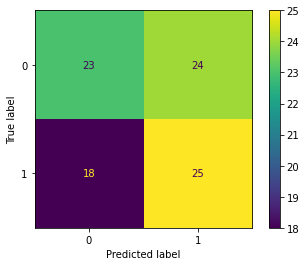

              precision    recall  f1-score   support

           0       0.56      0.49      0.52        47
           1       0.51      0.58      0.54        43

    accuracy                           0.53        90
   macro avg       0.54      0.54      0.53        90
weighted avg       0.54      0.53      0.53        90



In [20]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
# Creación del modelo
# ==============================================================================
modelo = RandomForestClassifier(
            n_estimators = 300,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
pred = modelo.predict(X = X_test)

importancesRF = pd.DataFrame(data={
    'Attribute': data_full.columns,
    'Importance': modelo.feature_importances_
})
importancesRF = importancesRF.sort_values(by='Importance', ascending=False)
plot_confusion_matrix(modelo, X_test, y_test)  
plt.show()
print(classification_report(y_test,pred))


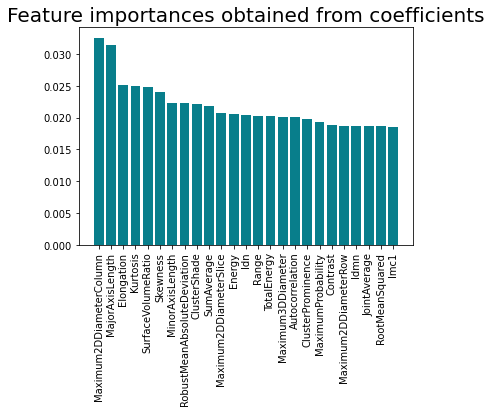

In [21]:
plt.bar(x=importancesRF['Attribute'][0:25], height=importancesRF['Importance'][0:25], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

Elegimos las 9 carácteristicas más importantes. :

In [22]:
x1=importancesRF['Attribute'][0:20]
data_top =data_full[x1]
X2 = StandardScaler().fit_transform(data_top)

X_train, X_test, y_train, y_test = train_test_split(X2, y_full, test_size=0.3, random_state=42)

## modelo con top features

Vamos a volver a entrenar el modelo Random Forest, pero ahora solo con las características más importantes. Veremos que los resultados mejoran. Aunque siguen estando lejos de ser buenos resultados

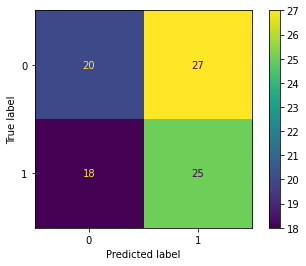

              precision    recall  f1-score   support

           0       0.53      0.43      0.47        47
           1       0.48      0.58      0.53        43

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.50      0.50      0.50        90



In [23]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import plot_confusion_matrix
# Creación del modelo
# ==============================================================================
modelo = RandomForestClassifier(
            n_estimators = 400,
            max_depth    = None,
            max_features = 'auto',
            oob_score    = True,
            n_jobs       = -1,
            random_state = 0
         )

# Entrenamiento del modelo
# ==============================================================================
modelo.fit(X_train, y_train)

# Error de test del modelo inicial
# ==============================================================================
pred = modelo.predict(X = X_test)

importances = pd.DataFrame(data={
    'Attribute': data_top.columns,
    'Importance': modelo.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)
plot_confusion_matrix(modelo, X_test, y_test)  
plt.show()
print(classification_report(y_test,pred))

## Exctraccion de características con XGBClassifier

Los modelos   xgboost nos permiten la opción de extraer las características y darnos un valor según su importancia. Vamos a utillizar este modelo para clasificar también nuestro dataset y después comprobaremos que nuestro modelo mejora al reducir las características y nos quedaremos con las 7 más importantes.

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

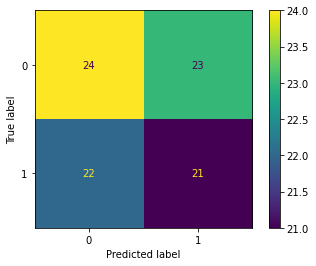

              precision    recall  f1-score   support

           0       0.52      0.51      0.52        47
           1       0.48      0.49      0.48        43

    accuracy                           0.50        90
   macro avg       0.50      0.50      0.50        90
weighted avg       0.50      0.50      0.50        90



In [25]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, objective = 'reg:logistic',learning_rate =  0.1,
                      colsample_bytree = 0.8, alpha = 6)
model.fit(X_train, y_train)
importancesXG = pd.DataFrame(data={
    'Attribute': data_full.columns,
    'Importance': model.feature_importances_
})
importancesXG = importancesXG.sort_values(by='Importance', ascending=False)

pred = model.predict(X = X_test)


plot_confusion_matrix(model, X_test, y_test)  
plt.show()
print(classification_report(y_test,pred))

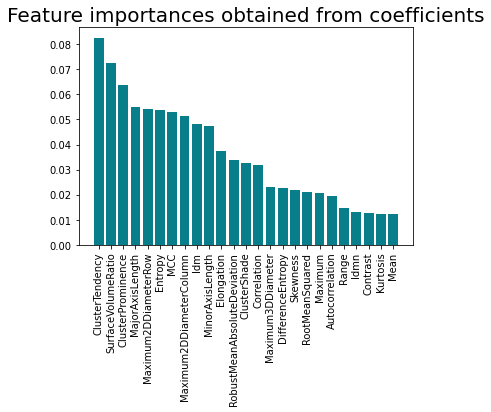

In [26]:
plt.bar(x=importancesXG['Attribute'][0:25], height=importancesXG['Importance'][0:25], color='#087E8B')
plt.title('Feature importances obtained from coefficients', size=20)
plt.xticks(rotation='vertical')
plt.show()

In [27]:
x2=importancesXG['Attribute'][0:20]
data_top =data_full[x2]
X2 = StandardScaler().fit_transform(data_top)
X_train, X_test, y_train, y_test = train_test_split(X2, y_full, test_size=0.3, random_state=42)


Pruebo un clasificador con las variables más importantes segun el random forest y un clasificador con las variables más importantes segun el  XGBClassifier:

####  XGBClassifier:

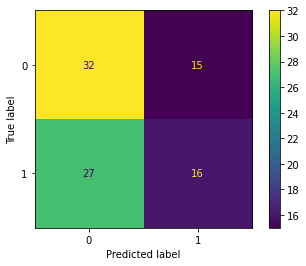

              precision    recall  f1-score   support

           0       0.54      0.68      0.60        47
           1       0.52      0.37      0.43        43

    accuracy                           0.53        90
   macro avg       0.53      0.53      0.52        90
weighted avg       0.53      0.53      0.52        90



In [28]:
from xgboost import XGBClassifier

model = XGBClassifier(use_label_encoder=False, objective = 'reg:logistic',learning_rate =1,
                      colsample_bytree = 0.7, alpha = 6)
model.fit(X_train, y_train)
importances = pd.DataFrame(data={
    'Attribute': data_top.columns,
    'Importance': model.feature_importances_
})
importances = importances.sort_values(by='Importance', ascending=False)

pred = model.predict(X = X_test)


plot_confusion_matrix(model, X_test, y_test)  
plt.show()
print(classification_report(y_test,pred))

## Gradient Boosting Classifier

Vamos a entrenar un clasificador con las variables más importantes segun los dos modelos anteriormente entrenados.

              precision    recall  f1-score   support

           0       0.70      0.64      0.67        47
           1       0.64      0.70      0.67        43

    accuracy                           0.67        90
   macro avg       0.67      0.67      0.67        90
weighted avg       0.67      0.67      0.67        90



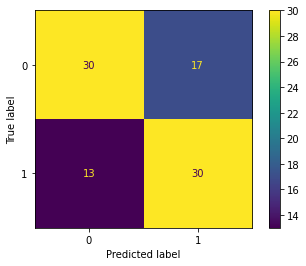

In [29]:
from sklearn.datasets import make_hastie_10_2
from sklearn.ensemble import GradientBoostingClassifier


clf = GradientBoostingClassifier(n_estimators=400, learning_rate=1,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)
pred =clf.predict(X_test)
print(classification_report(y_test,pred))
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

### Random forest features :


In [30]:
x1=importancesRF['Attribute'][0:20]
data_top =data_full[x1]
X2 = StandardScaler().fit_transform(data_top)

X_train, X_test, y_train, y_test = train_test_split(X2, y_full, test_size=0.3, random_state=42)

              precision    recall  f1-score   support

           0       0.62      0.60      0.61        47
           1       0.58      0.60      0.59        43

    accuracy                           0.60        90
   macro avg       0.60      0.60      0.60        90
weighted avg       0.60      0.60      0.60        90



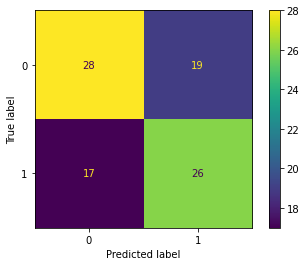

In [31]:
clf = GradientBoostingClassifier(n_estimators=400, learning_rate=1,
    max_depth=1, random_state=0).fit(X_train, y_train)
clf.score(X_test, y_test)
pred =clf.predict(X_test)
print(classification_report(y_test,pred))
plot_confusion_matrix(clf, X_test, y_test)  
plt.show()

## Conclusiones

* Vemos que las características extraidas segun el XGB nos permiten establecer un mejor clasificador que las caracteristicas extraídas vía Random Forest.


* Los resultados siguen siendo pobres, esto puede ser debido a que la detección de outliers que hemos utilizado  no sea la adecuada, y hayamos entrenado al modelo con segmentaciones erróneas


In [32]:
 print("Características más importantes segun el XGBC: ")
print(x2)


Características más importantes segun el XGBC: 
5                 ClusterTendency
51             SurfaceVolumeRatio
3               ClusterProminence
29                MajorAxisLength
32           Maximum2DDiameterRow
13                        Entropy
28                            MCC
31        Maximum2DDiameterColumn
16                            Idm
41                MinorAxisLength
11                     Elongation
43    RobustMeanAbsoluteDeviation
4                    ClusterShade
7                     Correlation
34              Maximum3DDiameter
9               DifferenceEntropy
45                       Skewness
44                RootMeanSquared
30                        Maximum
2                 Autocorrelation
Name: Attribute, dtype: object


In [33]:
print("Características más importantes segun el Random Forest: ")
print(x1)

Características más importantes segun el Random Forest: 
31        Maximum2DDiameterColumn
29                MajorAxisLength
11                     Elongation
26                       Kurtosis
51             SurfaceVolumeRatio
45                       Skewness
41                MinorAxisLength
43    RobustMeanAbsoluteDeviation
4                    ClusterShade
47                     SumAverage
33         Maximum2DDiameterSlice
12                         Energy
18                            Idn
42                          Range
52                    TotalEnergy
34              Maximum3DDiameter
2                 Autocorrelation
3               ClusterProminence
35             MaximumProbability
6                        Contrast
Name: Attribute, dtype: object


# Errores en la segmentación

## P.S. Warning
The segmentation doesn't not working properly on all images due to the different tumor modalities. The model was trained on low-grade tumors, so be aware. Let's see the examples

#### For this type of broken segmentation like in '00009' we could perform a little trick to fix. 
We need to multiply mask to the empty space of the original image

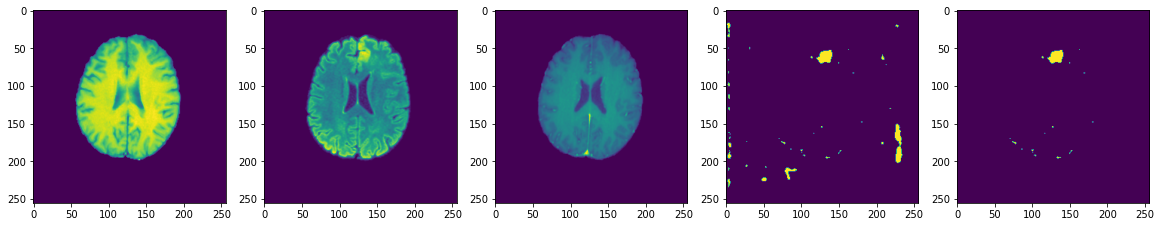

In [34]:
im = get_img(6)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model_unet(torch.Tensor(test_img))

f, axarr = plt.subplots(1,5, figsize=(20, 20))
axarr[0].imshow(test_img[0, 0])
axarr[1].imshow(test_img[0, 1])
axarr[2].imshow(test_img[0, 2])
axarr[3].imshow(test_res[0][0].detach().cpu().numpy() > 0.5)
axarr[4].imshow((test_res[0][0].detach().cpu().numpy() > 0.5) * (test_img[0, 1] != 0))

#### For the "00003" image the broken segmentation could be due to the bad registration and this trick won't work

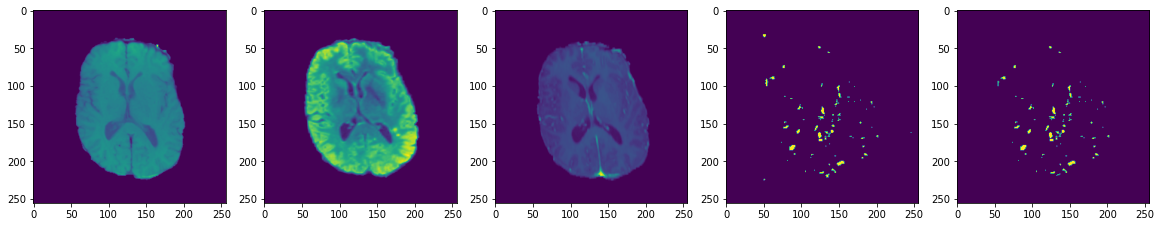

In [35]:
im = get_img(2)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model_unet(torch.Tensor(test_img))

f, axarr = plt.subplots(1,5, figsize=(20, 20))
axarr[0].imshow(test_img[0, 0])
axarr[1].imshow(test_img[0, 1])
axarr[2].imshow(test_img[0, 2])
axarr[3].imshow(test_res[0][0].detach().cpu().numpy() > 0.5)
axarr[4].imshow((test_res[0][0].detach().cpu().numpy() > 0.5) * (test_img[0, 1] != 0))

#### Let's see more examples of broken segmentation

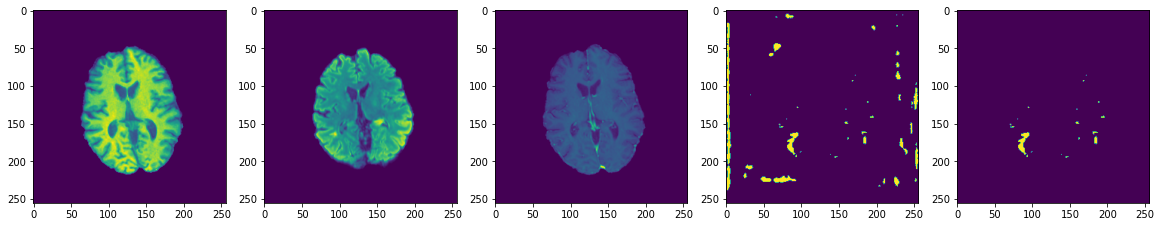

In [36]:
im = get_img(9)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model_unet(torch.Tensor(test_img))

f, axarr = plt.subplots(1,5, figsize=(20, 20))
axarr[0].imshow(test_img[0, 0])
axarr[1].imshow(test_img[0, 1])
axarr[2].imshow(test_img[0, 2])
axarr[3].imshow(test_res[0][0].detach().cpu().numpy() > 0.5)
axarr[4].imshow((test_res[0][0].detach().cpu().numpy() > 0.5) * (test_img[0, 1] != 0))

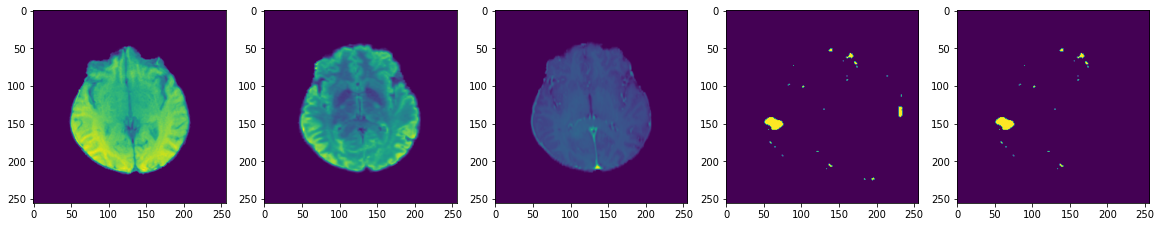

In [37]:
im = get_img(20)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model_unet(torch.Tensor(test_img))

f, axarr = plt.subplots(1,5, figsize=(20, 20))
axarr[0].imshow(test_img[0, 0])
axarr[1].imshow(test_img[0, 1])
axarr[2].imshow(test_img[0, 2])
axarr[3].imshow(test_res[0][0].detach().cpu().numpy() > 0.5)
axarr[4].imshow((test_res[0][0].detach().cpu().numpy() > 0.5) * (test_img[0, 1] != 0))

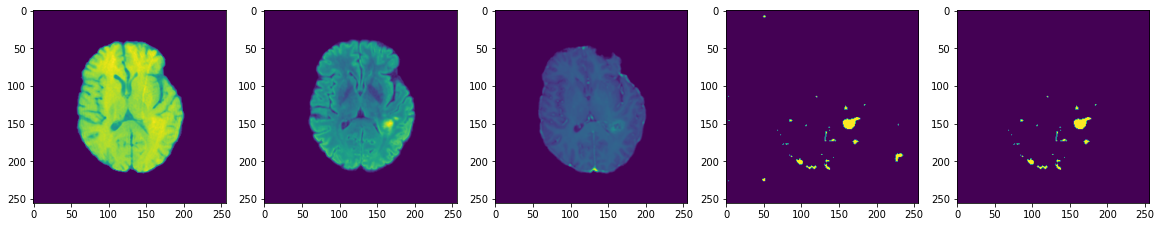

In [38]:
im = get_img(24)
test_img = np.array([np.moveaxis(np.array(im.resize((256, 256))), -1, 0)])
test_res = model_unet(torch.Tensor(test_img))

f, axarr = plt.subplots(1,5, figsize=(20, 20))
axarr[0].imshow(test_img[0, 0])
axarr[1].imshow(test_img[0, 1])
axarr[2].imshow(test_img[0, 2])
axarr[3].imshow(test_res[0][0].detach().cpu().numpy() > 0.5)
axarr[4].imshow((test_res[0][0].detach().cpu().numpy() > 0.5) * (test_img[0, 1] != 0))